**Leaderboard Distribution**

I have been doing this competetion for 4 days or so. 

The main problem that everybody is (including me hitting my head through the WALL) facing is the **local cross validation is not matching the LeaderBoard.**

In this kernel I try to create a Validation Set which matches the leaderboard using LeaderBoard Probing done by **@donkeys and @ninoko.**

The leaderboard distributions are given in the discussion threads : 

1. https://www.kaggle.com/c/career-con-2019/discussion/84760
2. https://www.kaggle.com/c/career-con-2019/discussion/85204

A **big thank you** for wasting your 9 submissions for the greater GOOD. 

So lets get into it.

**Importing Tools**

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import stats
import math

from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.simplefilter('ignore')

import gc
import itertools

**Reading Data**

In [54]:
train = pd.read_csv("../input/X_train.csv")
test = pd.read_csv("../input/X_test.csv")
label = pd.read_csv("../input/y_train.csv")
sub = pd.read_csv("../input/sample_submission.csv")

In [55]:
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

In [56]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 48.37 MB
Memory usage after optimization is: 14.88 MB
Decreased by 69.2%
Memory usage of dataframe is 48.45 MB
Memory usage after optimization is: 14.91 MB
Decreased by 69.2%


**Lets first check the Train Target Distribution** 

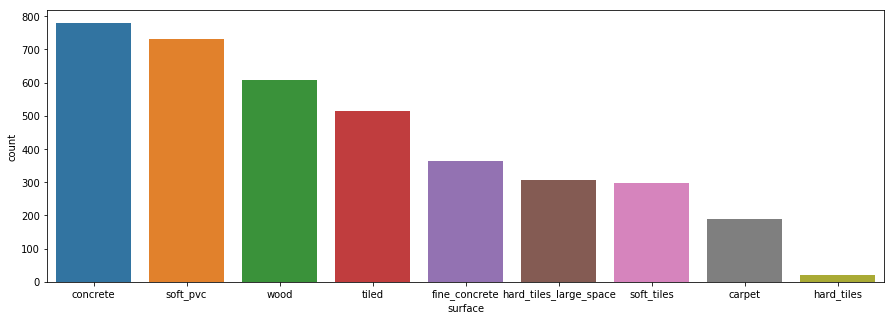

In [57]:
plt.figure(figsize=(15, 5))
sns.countplot(label['surface'], order=label.surface.value_counts().index)
plt.show()

**We have very less records for "hard_tiles".**

So it would most probably be very difficult for our RandomForest, LightGBM to detect and correctly classify the hard_tiles.

The below is a distribution of the leaderboard probe given in the thread : https://www.kaggle.com/c/career-con-2019/discussion/84760

<img src="https://i.imgur.com/DoFc3mW.png" />

We can see that the leaderboard has quite different distibition than in our test.

The different distributions lie in : 

**1. High Local Predictions for Wood but less on the Leaderboard set.**

**2. High Local Predictions for Tiled but less on the Leaderboard set.**

**3. Low Local Predictions for Soft_Tiles but high on the Leaderboard set.**

**4. Many records of type hard_tiles in the Leaderboard set. **

Lets instigate more. :/

In [58]:
# This is a dictionary consisting of the weights of the distributions for each target class from the below discussion thread.
# https://www.kaggle.com/c/career-con-2019/discussion/85204#latest-496648

def create_valid_set(label):
    # Lets try creating a validation set of 10% of the total size.
    ldict = {
        'concrete': 0.16,
        'soft_pvc': 0.18,
        'wood': 0.06,
        'tiled': 0.03,
        'fine_concrete': 0.10,
        'hard_tiles_large_space': 0.12,
        'soft_tiles': 0.23,
        'carpet': 0.05,
        'hard_tiles': 0.07,
    }
    score = 0
    print("Required count of target classes for the Valid Set :: ")
    for key, value in ldict.items():
        score += value
        print(key, int(value * 380)) # Multiplying by 380 i.e 10% of 3810 for our validation size of 10%.
        ldict[key] = int(value * 380)
    print("\nTotal Weights of class :: ", score)
    
    # Grouping surface with group_id and the count attached to each surface.
    ser = label.groupby(['surface'])['group_id'].value_counts()
    ser = pd.DataFrame(ser)
    ser.columns = ['count']
    
    # Maually creating the valid set using the counts using the required count and the count we have in the train set.
    # This dictionary consists of the group_id for the required valid set. 
    cv_set = {
        'concrete': [0],
        'soft_pvc': [69],
        'wood': [2],
        'tiled': [28],
        'fine_concrete': [36],
        'hard_tiles_large_space': [16],
        'soft_tiles': [4, 17],
        'carpet': [52],
        'hard_tiles': [27],
    }

    cv_size = 0
    for key, value in cv_set.items():
        print(key)
        for i in value:
            cv_size += label[label['group_id'] == i].shape[0]
            print("\nGot shape :: ", label[label['group_id'] == i].shape[0])
        print("Expected shape :: ", ldict[key])
    
    val_df = pd.DataFrame()
    for key, value in cv_set.items():
        for i in value:
            val_df = pd.concat([val_df, label[label['group_id'] == i]])
    print("Valid Set Size :: ", val_df.shape[0])
    
    # We have only 1 group_id for the hard_tiles and it consists of only 21 records.
    # So we have added the same group_id in the train as well as valid set. GROUP_ID = 27(for "hard_tiles")
    hard_tiles_index = label[(label['surface'] == 'hard_tiles') & (label['group_id'] == 27)].index
    
    # Therefore train set = Total Set series_id - Valid Set series_id + Hard_Tiles.index
    trn_series_id_list = list(set(label.series_id.unique()) - set(val_df.series_id.unique())) + hard_tiles_index.tolist()
    
    print("Train Set Distribution")
    print(label['surface'].iloc[trn_series_id_list].value_counts())
    
    print("Valid Set Distribution")
    print(label['surface'].iloc[val_df.index].value_counts())
    
    trn_df = label.iloc[trn_series_id_list]
    
    trn_df.set_index(['series_id'], inplace=True)
    val_df.set_index(['series_id'], inplace=True)
    
    return trn_df, val_df

In [59]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)
    
    return X, Y, Z

**Highly Influenced by the kernels : **

1. https://www.kaggle.com/prashantkikani/help-humanity-by-helping-robots/

2. https://www.kaggle.com/jesucristo/my-best-helping-robots-0-72

In [60]:
def FE(data):
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                            data['orientation_Z']**2)**0.5
    data['z_planar_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2)**0.5
    #Lets derive one more column since there is a relationship in velocity and acceleration
    # v = u + a*t , u is initial velocty. if u = 0, then v = at means t = v/a
    # but value of acceleration is more and value of velocity is less, lets do a/v relation
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    # Deriving more feature, since we are reducing rows now, we should know min,max,mean values
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [ ]:
%%time

trn_df, val_df = create_valid_set(label)
train = FE(train)
test = FE(test)

Required count of target classes for the Valid Set :: 
concrete 60
soft_pvc 68
wood 22
tiled 11
fine_concrete 38
hard_tiles_large_space 45
soft_tiles 87
carpet 19
hard_tiles 26

Total Weights of class ::  1.0
concrete

Got shape ::  57
Expected shape ::  60
soft_pvc

Got shape ::  70
Expected shape ::  68
wood

Got shape ::  18
Expected shape ::  22
tiled

Got shape ::  36
Expected shape ::  11
fine_concrete

Got shape ::  36
Expected shape ::  38
hard_tiles_large_space

Got shape ::  45
Expected shape ::  45
soft_tiles

Got shape ::  57

Got shape ::  12
Expected shape ::  87
carpet

Got shape ::  11
Expected shape ::  19
hard_tiles

Got shape ::  21
Expected shape ::  26
Valid Set Size ::  363
Train Set Distribution
concrete                  722
soft_pvc                  662
wood                      589
tiled                     478
fine_concrete             327
hard_tiles_large_space    263
soft_tiles                228
carpet                    178
hard_tiles                 21
Na

**Label Encoding our target classes**

In [ ]:
le = LabelEncoder()
label['surface'] = le.fit_transform(label['surface'])

**Filling missing and infinite data by zeroes**

In [ ]:
train.fillna(0,inplace=True)
train.replace(-np.inf,0,inplace=True)
train.replace(np.inf,0,inplace=True)
test.fillna(0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

In [ ]:
x_train = train.iloc[trn_df.index]
y_train = label['surface'].iloc[trn_df.index]

x_val = train.iloc[val_df.index]
y_val = label['surface'].iloc[val_df.index]

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

**The function below check the Train, Test, and CV Scores of the trained model.**

**Lets Check.**

In [ ]:
def lb_dist(model):
    model.fit(x_train, y_train)
    print("Train Acc :: ", accuracy_score(y_train, model.predict(x_train)))
    print("Valid Acc :: ", accuracy_score(y_val, model.predict(x_val)))
    print("CV Accuracy :: ", cross_val_score(rand, train, label['surface'], cv=5).mean())

    return model

In [ ]:
rand = RandomForestClassifier(n_estimators=500, random_state=13)
rand = lb_dist(rand)

Well those three lines state my pain of matching local CV to LeaderBoard.

Lets understand what those 3 lines say:
1. Our Classifier is overfitting like HELL.
2. Cross Validation is also misleading as : 
            a. Test Distribution is different from the Train Distribution.
            b. In CV some splits might end up not even considering the "hard_tiles" class as it has only 21 records.
            c. The "hard_tiles" and "soft_tiles" hold quite a lot in the leaderboard.

So we must find features which could help us classifying classes like  :  "hard_tiles", "soft_tiles", "tiled", "wood" as they have very different Train and LeaderBoard distributions.

**Lets check Confusion Matrix and see how our Classifier is doing.**

In [ ]:
plot_confusion_matrix(y_val, rand.predict(x_val), classes=le.classes_)

**Understanding the Confusion Matrix**

This plot states so much that is very valuable in what to do next to **increase our SCORE.**

What I learnt from this plot : 

**1. The diagonal in confusion matrix should always look bright i.e more populated in the whole matrix which means that the True Labels and the Predicted Labels must be same (or we should maximise that).**

Example of a **Good Confusion Matrix **

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_002.png" />

**2. Worst Classified Classes are :**

        a. Carpet - 1 correctly classified out of 11.
        b. Concrete - 57 out of 57 (Might be Overfit).
        c. Fine_Concrete - 0 out of 36 (WHAT!!!)
        d. Hard_Tiles - 21 out of 21 (Might be Overfit).
        e. Hard_Tiles_Large_Space - 0 out of 45 (WHAT!!!)
        f. Soft_PVC - 66 out of 70 (GREAT) 
        g. Soft_Tiles - 53 ou tof 69 (I can live with that.)
        h. Tiled - 33 out of 36 (GREAT)
        i. Wood - 0 out of 18 (You kidding?)


**This Confusion Matrix reveals the major faults in our RandomForestClassifier.**

**So fixing these faults would/should mean an increase in score. (FOR SURE)**

In [ ]:
print("Accuracy Score :: ", accuracy_score(label['surface'], rand.predict(train)))
plot_confusion_matrix(label['surface'], rand.predict(train), classes=le.classes_)

**We can see that the Classifier is clearly overfitting by getting 96% in local CV and check the matrix!!**

**That is one clean and bright diagonal.** (Just if I had that for the Leaderboard  **** *******__*******  )

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((train.shape[0]))
score = 0

In [ ]:
for times, (trn_idx, val_idx) in enumerate(folds.split(train.values, label['surface'].values)):
    model = RandomForestClassifier(n_estimators=500, random_state=13)
    model.fit(train.iloc[trn_idx], label['surface'][trn_idx])
    measured[val_idx] = model.predict(train.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(train.iloc[val_idx], label['surface'][val_idx])
    print("Fold: {} score: {}".format(times, model.score(train.iloc[val_idx], label['surface'][val_idx])))
    gc.collect()


**Submitting our Predictions**

In [ ]:
sub['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sub.to_csv('rand_sub_10.csv', index=False)
sub.head()

**This submission scores 0.71 on LeaderBoard and we got a Validation Accuracy of 0.64. I think that might be good enough.**

**Checking our predictions for the Test Set**

In [ ]:
sub.surface.value_counts()

This was my first kernel, so please spare me and everybody is welcome for their suggestions in the comments.

** **CONCLUSION** :: Understanding the confusion matrix and solving the problem of the imbalance in the target classes is defintly the way to go for increasing the Accuracy Score.**

References :: 

Feature Engineering : 

1. https://www.kaggle.com/prashantkikani/help-humanity-by-helping-robots/

2. https://www.kaggle.com/jesucristo/my-best-helping-robots-0-72

LeaderBoard Probing

1. https://www.kaggle.com/c/career-con-2019/discussion/84760

2. https://www.kaggle.com/c/career-con-2019/discussion/85204
 



**Thanks** for your time and **UPVOTE** if you liked it and decide to try the same. 